In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, BatchNormalization
import keras_tuner as kt
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=FutureWarning, module="tensorflow")

In [2]:
num_days = 100
data_array = np.random.random((num_days, 24, 25))  # Replace with your actual TEC data

# Reshape data for ConvLSTM (samples, timesteps, rows, cols, channels)
X = np.zeros((num_days-3, 3, 24, 25, 1))
y = np.zeros((num_days-3, 24*25))

# Create input-output pairs: 3 consecutive days to predict the 4th
for i in range(num_days-3):
    for j in range(3):
        X[i, j, :, :, 0] = data_array[i+j]
    y[i] = data_array[i+3].flatten()

# Split into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training on {train_size} samples, testing on {len(X) - train_size} samples")

Training on 77 samples, testing on 20 samples


In [3]:
def build_convlstm_model(hp):
    model = Sequential()
    
    # Tune number of filters
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    
    # Tune kernel size
    kernel_size = hp.Choice('kernel_size', values=[3, 5])
    
    # ConvLSTM layer
    model.add(ConvLSTM2D(
        filters=filters,
        kernel_size=(kernel_size, kernel_size),
        padding='same',
        activation='relu',
        input_shape=(3, 24, 25, 1)
    ))
    
    # Optional batch normalization
    if hp.Boolean('use_batch_norm'):
        model.add(BatchNormalization())
    
    model.add(Flatten())
    
    # Optional dense layer
    if hp.Boolean('use_dense'):
        dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)
        model.add(Dense(dense_units, activation='relu'))
    
    # Output layer
    model.add(Dense(24*25))
    
    # Tune learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    
    return model

In [ ]:
# Initialize the tuner
tuner = kt.BayesianOptimization(
    build_convlstm_model,
    objective='val_loss',
    max_trials=10,
    directory='tec_tuning_results',
    project_name='tec_convlstm'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

I0000 00:00:1744253478.789136    9425 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/adhidevx369-work/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Search for optimal hyperparameters
print("Starting hyperparameter search...")
tuner.search(
    X_train, y_train,
    epochs=15,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 00m 28s]
val_loss: 0.08431963622570038

Best val_loss So Far: 0.08408224582672119
Total elapsed time: 00h 02m 56s


In [6]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest hyperparameters:")
print(f"- Filters: {best_hps.get('filters')}")
print(f"- Kernel size: {best_hps.get('kernel_size')}")
print(f"- Using batch normalization: {best_hps.get('use_batch_norm')}")
print(f"- Using dense layer: {best_hps.get('use_dense')}")
if best_hps.get('use_dense'):
    print(f"  - Dense units: {best_hps.get('dense_units')}")
print(f"- Learning rate: {best_hps.get('learning_rate'):.6f}")


Best hyperparameters:
- Filters: 96
- Kernel size: 5
- Using batch normalization: False
- Using dense layer: False
- Learning rate: 0.000524


/home/adhidevx369-work/miniconda3/envs/dl/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
print("\nTraining the optimal model...")
history = best_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Training the optimal model...
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0736 - val_loss: 0.0883
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 0.0698 - val_loss: 0.0880
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step - loss: 0.0655 - val_loss: 0.0848
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0604 - val_loss: 0.0856
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0555 - val_loss: 0.0866
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0516 - val_loss: 0.0860
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0467 - val_loss: 0.0867
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0426 - val_loss: 0.0873


In [8]:
test_loss = best_model.evaluate(X_test, y_test)
print(f"\nTest MSE: {test_loss:.4f}")
predictions = best_model.predict(X_test)
daily_mse = [np.mean((y_test[i] - predictions[i])**2) for i in range(len(y_test))]

2025-04-10 08:28:33.063079: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.20 = (f32[20,96,24,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,1,24,25]{3,2,1,0} %bitcast.662, f32[96,1,5,5]{3,2,1,0} %bitcast.667, f32[96]{0} %bitcast.670, f32[20,96,24,25]{3,2,1,0} %bitcast.683), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv_lstm2d_1/while/conv_lstm_cell_1/convolution_3" source_file="/home/adhidevx369-work/miniconda3/envs/dl/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":1,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-10 08:28:33.116212: I ext

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0859

Test MSE: 0.0859
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


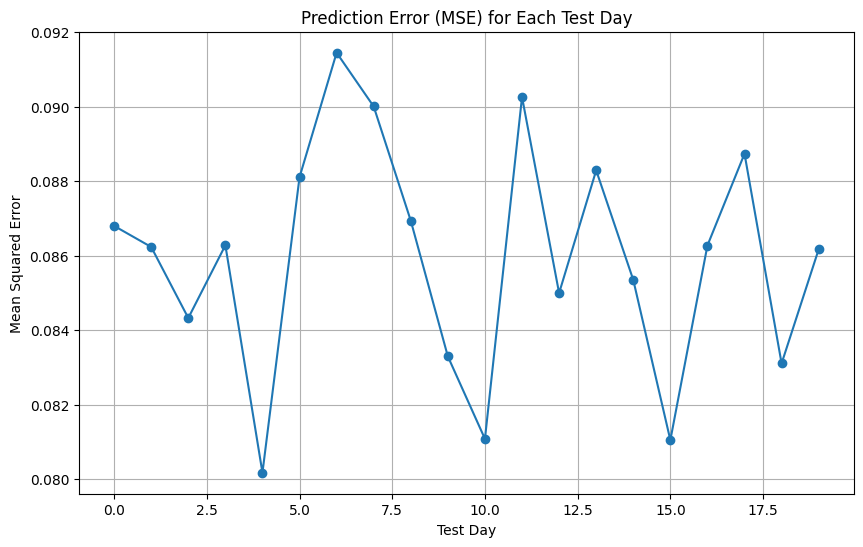

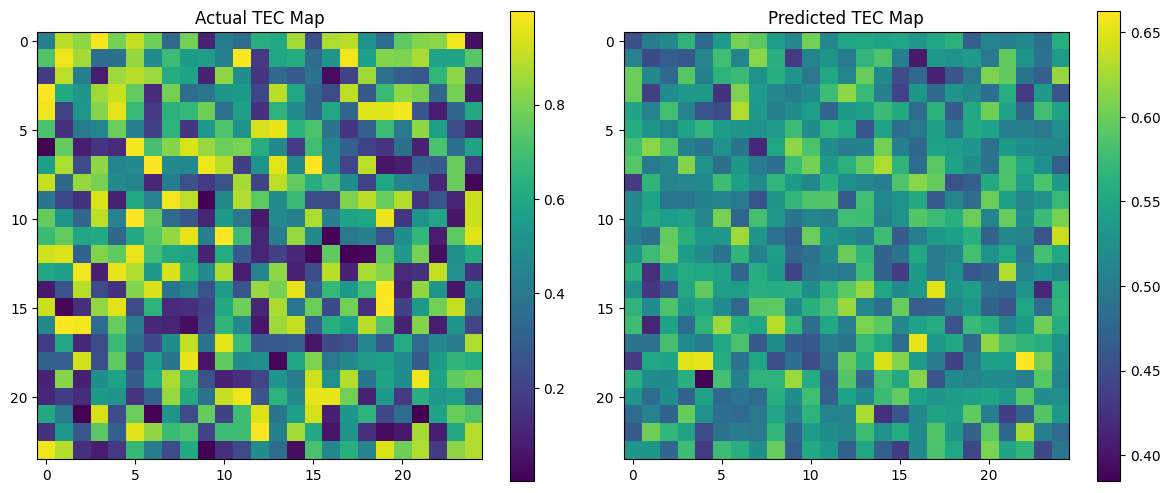

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(daily_mse)), daily_mse, marker='o')
plt.title('Prediction Error (MSE) for Each Test Day')
plt.xlabel('Test Day')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.savefig('tec_prediction_results.png')
plt.show()

day_idx = 0
pred_map = predictions[day_idx].reshape(24, 25)
actual_map = y_test[day_idx].reshape(24, 25)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(actual_map, cmap='viridis')
plt.title('Actual TEC Map')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(pred_map, cmap='viridis')
plt.title('Predicted TEC Map')
plt.colorbar()

plt.tight_layout()
plt.savefig('tec_map_comparison.png')
plt.show()